In [15]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20
latent_dim = 20
x_dim = 784
hidden_dim = 400

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [29]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.ReLU()
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        
        x_hat = self.decoder(x)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


def vae_loss_function(reconstructed_x, x, means, log_variances):
    #Compute the VAE loss
    #The loss is a sum of two terms: reconstruction error and KL divergence
    #Use cross entropy loss between x and reconstructed_x for the reconstruction error (as opposed to L2 loss as discussed in lecture -- this is sometimes done for data in [0,1] for easier optimization)
    #The KL divergence is -1/2 * sum(1 + log_variances - means^2 - exp(log_variances)) as described in lecture
    #Returns loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstructed_x, x)
    kl_loss = -0.5 * torch.sum(1 + log_variances - means ** 2 - torch.exp(log_variances))
    loss = reconstruction_loss + kl_loss
    return loss, reconstruction_loss

In [ ]:
def train(model, optimizer):
    #Trains the VAE for one epoch on the training dataset
    #Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    model.train()
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss, _ = vae_loss_function(x_hat, x, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    avg_train_loss = overall_loss / len(train_loader)
    return avg_train_loss

Epoch #1


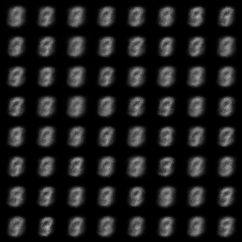



Epoch #2


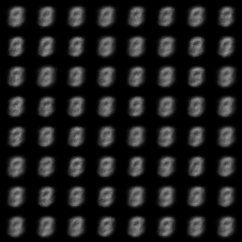

KeyboardInterrupt: 

In [44]:
epochs = 50
avg_train_losses = []
avg_train_reconstruction_losses = []
avg_test_losses = []
avg_test_reconstruction_losses = []
vae_optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    avg_train_loss = train(model, vae_optimizer)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = model.Decoder(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')



